In [1]:
import pandas as pd

In [2]:
df_1 = pd.read_csv('./training_data_09-20-2022-20-26-56.csv')
df = pd.concat([df_1])

# Analyse Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8347 entries, 0 to 8346
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8347 non-null   int64  
 1   i_sensor_1  8347 non-null   int64  
 2   i_sensor_2  8347 non-null   int64  
 3   i_sensor_3  8347 non-null   int64  
 4   o_left      8347 non-null   bool   
 5   o_right     8347 non-null   bool   
 6   i_sensor_4  8347 non-null   float64
 7   i_sensor_5  8347 non-null   float64
dtypes: bool(2), float64(2), int64(4)
memory usage: 407.7 KB


<AxesSubplot:>

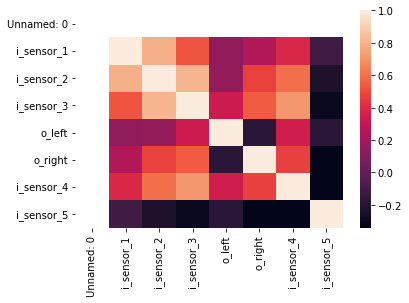

In [4]:
import seaborn as sns
sns.heatmap(df.corr())

# Scale/convert input values

In [5]:
df = df.astype({'o_left': int, 'o_right': int})   

In [6]:
df.head()

,Unnamed: 0,i_sensor_1,i_sensor_2,i_sensor_3,o_left,o_right,i_sensor_4,i_sensor_5
0,0,40,46,45,0,0,128.0,199.0
1,0,40,46,45,0,0,125.0,199.0
2,0,40,46,45,0,0,123.0,199.0
3,0,40,46,45,0,0,121.0,199.0
4,0,40,46,45,0,0,117.0,199.0


In [7]:
df[df['o_left']==1]

,Unnamed: 0,i_sensor_1,i_sensor_2,i_sensor_3,o_left,o_right,i_sensor_4,i_sensor_5
738,0,35,45,45,1,0,48.0,199.0
739,0,35,44,45,1,0,48.0,200.0
740,0,35,43,45,1,0,48.0,200.0
741,0,35,43,44,1,0,49.0,199.0
742,0,35,43,44,1,0,49.0,200.0
...,...,...,...,...,...,...,...,...
7993,0,39,40,45,1,0,46.0,200.0
7994,0,39,40,45,1,0,47.0,200.0
8166,0,38,41,46,1,0,46.0,200.0
8167,0,38,41,46,1,0,46.0,200.0


# Set Train and test 

In [8]:
from sklearn.model_selection import train_test_split
X = df.drop(['o_left','o_right','Unnamed: 0'],axis=1).values
y = df[['o_left','o_right']].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=101)

# Create neural network

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout

In [10]:
import os
model = Sequential()

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",
    min_delta=0.1,
    patience=500,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

X_train.shape

(5842, 5)

In [11]:
model.add(Dense(units=30, input_dim=5,activation='relu'))

model.add(Dense(units=30,activation='relu'))

model.add(Dense(units=30,activation='relu'))

model.add(Dense(units=30,activation='relu'))

model.add(Dense(units=30,activation='relu'))

model.add(Dense(2,activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model

In [ ]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=8000,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stopping]
         )

Epoch 1/8000
183/183 [==============================] - 1s 2ms/step - loss: 0.3585 - accuracy: 0.4935 - val_loss: 0.3316 - val_accuracy: 0.5138
Epoch 2/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.3255 - accuracy: 0.4771 - val_loss: 0.3224 - val_accuracy: 0.6838
Epoch 3/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.3201 - accuracy: 0.3824 - val_loss: 0.3214 - val_accuracy: 0.2451
Epoch 4/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.3109 - accuracy: 0.3803 - val_loss: 0.3073 - val_accuracy: 0.2854
Epoch 5/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.3089 - accuracy: 0.3187 - val_loss: 0.3075 - val_accuracy: 0.2467
Epoch 6/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.3017 - accuracy: 0.3519 - val_loss: 0.3079 - val_accuracy: 0.3014
Epoch 7/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.2939 - accuracy: 0.3208 - val_loss: 0.3114 - val_accuracy:

183/183 [==============================] - 0s 1ms/step - loss: 0.1939 - accuracy: 0.5556 - val_loss: 0.1968 - val_accuracy: 0.6168
Epoch 58/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1979 - accuracy: 0.5318 - val_loss: 0.2125 - val_accuracy: 0.7034
Epoch 59/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1901 - accuracy: 0.5125 - val_loss: 0.2013 - val_accuracy: 0.4790
Epoch 60/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1863 - accuracy: 0.5464 - val_loss: 0.2070 - val_accuracy: 0.5018
Epoch 61/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1921 - accuracy: 0.5164 - val_loss: 0.2127 - val_accuracy: 0.5034
Epoch 62/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1886 - accuracy: 0.5197 - val_loss: 0.2073 - val_accuracy: 0.5246
Epoch 63/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1885 - accuracy: 0.5483 - val_loss: 0.2006 - val_accuracy: 0.6479

183/183 [==============================] - 0s 1ms/step - loss: 0.1578 - accuracy: 0.5642 - val_loss: 0.1649 - val_accuracy: 0.6236
Epoch 114/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1544 - accuracy: 0.5793 - val_loss: 0.1658 - val_accuracy: 0.5725
Epoch 115/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1552 - accuracy: 0.5787 - val_loss: 0.1850 - val_accuracy: 0.3936
Epoch 116/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1508 - accuracy: 0.5769 - val_loss: 0.1692 - val_accuracy: 0.4910
Epoch 117/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1514 - accuracy: 0.5561 - val_loss: 0.1702 - val_accuracy: 0.6271
Epoch 118/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1522 - accuracy: 0.5964 - val_loss: 0.1578 - val_accuracy: 0.5198
Epoch 119/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1489 - accuracy: 0.5892 - val_loss: 0.1597 - val_accuracy: 

183/183 [==============================] - 0s 1ms/step - loss: 0.1324 - accuracy: 0.5835 - val_loss: 0.1490 - val_accuracy: 0.5214
Epoch 170/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1335 - accuracy: 0.5852 - val_loss: 0.1675 - val_accuracy: 0.7250
Epoch 171/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1378 - accuracy: 0.6157 - val_loss: 0.1524 - val_accuracy: 0.6850
Epoch 172/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1341 - accuracy: 0.5948 - val_loss: 0.1672 - val_accuracy: 0.4970
Epoch 173/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1499 - accuracy: 0.5661 - val_loss: 0.1837 - val_accuracy: 0.6084
Epoch 174/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1348 - accuracy: 0.5832 - val_loss: 0.1450 - val_accuracy: 0.6363
Epoch 175/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1298 - accuracy: 0.5882 - val_loss: 0.1828 - val_accuracy: 

183/183 [==============================] - 0s 1ms/step - loss: 0.1197 - accuracy: 0.6161 - val_loss: 0.1387 - val_accuracy: 0.5689
Epoch 226/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1229 - accuracy: 0.5811 - val_loss: 0.1325 - val_accuracy: 0.7162
Epoch 227/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1187 - accuracy: 0.6025 - val_loss: 0.1407 - val_accuracy: 0.6607
Epoch 228/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1253 - accuracy: 0.6147 - val_loss: 0.1551 - val_accuracy: 0.7369
Epoch 229/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1178 - accuracy: 0.6250 - val_loss: 0.1455 - val_accuracy: 0.6782
Epoch 230/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1212 - accuracy: 0.6210 - val_loss: 0.1341 - val_accuracy: 0.6228
Epoch 231/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1245 - accuracy: 0.5959 - val_loss: 0.1587 - val_accuracy: 

183/183 [==============================] - 0s 1ms/step - loss: 0.1136 - accuracy: 0.5945 - val_loss: 0.1342 - val_accuracy: 0.5058
Epoch 282/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1114 - accuracy: 0.5952 - val_loss: 0.1400 - val_accuracy: 0.6052
Epoch 283/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1088 - accuracy: 0.6119 - val_loss: 0.1332 - val_accuracy: 0.5964
Epoch 284/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1214 - accuracy: 0.6077 - val_loss: 0.2559 - val_accuracy: 0.5373
Epoch 285/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1353 - accuracy: 0.6311 - val_loss: 0.1515 - val_accuracy: 0.5381
Epoch 286/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1179 - accuracy: 0.6354 - val_loss: 0.1678 - val_accuracy: 0.5705
Epoch 287/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1084 - accuracy: 0.6111 - val_loss: 0.1362 - val_accuracy: 

183/183 [==============================] - 0s 1ms/step - loss: 0.1043 - accuracy: 0.6097 - val_loss: 0.1233 - val_accuracy: 0.6475
Epoch 338/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1001 - accuracy: 0.6097 - val_loss: 0.1336 - val_accuracy: 0.6719
Epoch 339/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1136 - accuracy: 0.6238 - val_loss: 0.1490 - val_accuracy: 0.5265
Epoch 340/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1070 - accuracy: 0.5880 - val_loss: 0.1403 - val_accuracy: 0.6479
Epoch 341/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1116 - accuracy: 0.6236 - val_loss: 0.1569 - val_accuracy: 0.6323
Epoch 342/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1075 - accuracy: 0.6339 - val_loss: 0.1312 - val_accuracy: 0.4822
Epoch 343/8000
183/183 [==============================] - 0s 1ms/step - loss: 0.1090 - accuracy: 0.6070 - val_loss: 0.1257 - val_accuracy: 

In [ ]:
model_loss = pd.DataFrame(model.history.history)

In [ ]:
model_loss.plot()

In [51]:
model.save('car_game_model.h5')

In [52]:
import keras
model = keras.models.load_model('car_game_model.h5')

In [53]:
from car_game.car_game import CarGame
from car_game.road_enum import RoadEnum
    
car_game = CarGame(screen_size=(1280, 720), car_speed=1, frame_rate=60,
                   road=RoadEnum.TWO, sensor_threshold=200, generate_train_data=False, nn_model=model, 
                   probability_to_decide=0.8)

car_game.start_game()


90
1/1 [==============================] - 0s 50ms/step
[[9.999995e-01 4.884286e-07]]
93
1/1 [==============================] - 0s 15ms/step
[[9.999999e-01 8.756661e-08]]
96
1/1 [==============================] - 0s 13ms/step
[[1.0000000e+00 4.2486516e-08]]
99
1/1 [==============================] - 0s 12ms/step
[[1.0000000e+00 5.1153766e-09]]
102
1/1 [==============================] - 0s 12ms/step
[[1.0000000e+00 1.7613655e-08]]
105
1/1 [==============================] - 0s 12ms/step
[[2.169564e-12 1.000000e+00]]
102
1/1 [==============================] - 0s 12ms/step
[[1.0000000e+00 1.2116782e-09]]
105
1/1 [==============================] - 0s 13ms/step
[[0.9846942  0.01530582]]
108
1/1 [==============================] - 0s 11ms/step
[[4.8190394e-15 1.0000000e+00]]
105
1/1 [==============================] - 0s 12ms/step
[[1.0000000e+00 2.6564253e-09]]
108
1/1 [==============================] - 0s 11ms/step
[[0.93818444 0.06181559]]
111
1/1 [==============================] - 0s 12ms/ste

1/1 [==============================] - 0s 13ms/step
[[0.115499   0.88450104]]
90
1/1 [==============================] - 0s 13ms/step
[[0.115499   0.88450104]]
90
1/1 [==============================] - 0s 12ms/step
[[0.115499   0.88450104]]
90
1/1 [==============================] - 0s 12ms/step
[[0.115499   0.88450104]]
90
1/1 [==============================] - 0s 11ms/step
[[0.115499   0.88450104]]
90
1/1 [==============================] - 0s 11ms/step
[[0.115499   0.88450104]]
90
1/1 [==============================] - 0s 11ms/step
[[0.115499   0.88450104]]
90
1/1 [==============================] - 0s 18ms/step
[[0.115499   0.88450104]]
90
1/1 [==============================] - 0s 12ms/step
[[0.115499   0.88450104]]
90
1/1 [==============================] - 0s 11ms/step
[[0.115499   0.88450104]]
90
1/1 [==============================] - 0s 12ms/step
[[0.115499   0.88450104]]
90
1/1 [==============================] - 0s 11ms/step
[[0.115499   0.88450104]]
90
1/1 [=======================

1/1 [==============================] - 0s 11ms/step
[[0.45511994 0.5448801 ]]
90
1/1 [==============================] - 0s 12ms/step
[[0.45511994 0.5448801 ]]
90
1/1 [==============================] - 0s 11ms/step
[[0.45511994 0.5448801 ]]
90
1/1 [==============================] - 0s 12ms/step
[[0.45511994 0.5448801 ]]
90
1/1 [==============================] - 0s 13ms/step
[[0.45511994 0.5448801 ]]
90
1/1 [==============================] - 0s 12ms/step
[[0.45511994 0.5448801 ]]
90
1/1 [==============================] - 0s 12ms/step
[[0.45511994 0.5448801 ]]
90
1/1 [==============================] - 0s 12ms/step
[[0.45511994 0.5448801 ]]
90
1/1 [==============================] - 0s 12ms/step
[[0.4233456  0.57665443]]
90
1/1 [==============================] - 0s 12ms/step
[[0.4233456  0.57665443]]
90
1/1 [==============================] - 0s 12ms/step
[[0.4233456  0.57665443]]
90
1/1 [==============================] - 0s 11ms/step
[[0.32091287 0.67908716]]
90
1/1 [=======================

1/1 [==============================] - 0s 11ms/step
[[0.998723   0.00127705]]
129
1/1 [==============================] - 0s 12ms/step
[[0.01773597 0.9822641 ]]
126
1/1 [==============================] - 0s 12ms/step
[[0.99793446 0.00206551]]
129
1/1 [==============================] - 0s 11ms/step
[[0.07692225 0.9230778 ]]
126
1/1 [==============================] - 0s 12ms/step
[[9.9999976e-01 2.0456262e-07]]
129
1/1 [==============================] - 0s 12ms/step
[[0.44690603 0.553094  ]]
129
1/1 [==============================] - 0s 12ms/step
[[0.94656694 0.05343302]]
132
1/1 [==============================] - 0s 12ms/step
[[0.0107409 0.9892592]]
129
1/1 [==============================] - 0s 11ms/step
[[0.9961893  0.00381072]]
132
1/1 [==============================] - 0s 11ms/step
[[0.9236585  0.07634155]]
135
1/1 [==============================] - 0s 13ms/step
[[1.1405497e-06 9.9999881e-01]]
132
1/1 [==============================] - 0s 12ms/step
[[0.38449705 0.6155029 ]]
132
1/1 [=

1/1 [==============================] - 0s 12ms/step
[[4.4057981e-04 9.9955946e-01]]
345
1/1 [==============================] - 0s 11ms/step
[[7.325749e-04 9.992674e-01]]
342
1/1 [==============================] - 0s 11ms/step
[[7.325749e-04 9.992674e-01]]
339
1/1 [==============================] - 0s 12ms/step
[[7.325749e-04 9.992674e-01]]
336
1/1 [==============================] - 0s 12ms/step
[[7.325749e-04 9.992674e-01]]
333
1/1 [==============================] - 0s 11ms/step
[[7.325749e-04 9.992674e-01]]
330
1/1 [==============================] - 0s 11ms/step
[[7.325749e-04 9.992674e-01]]
327
1/1 [==============================] - 0s 12ms/step
[[7.325749e-04 9.992674e-01]]
324
1/1 [==============================] - 0s 11ms/step
[[7.325749e-04 9.992674e-01]]
321
1/1 [==============================] - 0s 11ms/step
[[4.4057981e-04 9.9955946e-01]]
318
1/1 [==============================] - 0s 11ms/step
[[7.325749e-04 9.992674e-01]]
315
1/1 [==============================] - 0s 11ms/ste